In [59]:
import torch
import torch.nn as nn
import os
import math
from sklearn.decomposition import PCA

In [60]:
class MGP(nn.Module):
    def __init__(self, X_L, y_L, X_H, y_H, feature_dim):
        super(MGP, self).__init__()
        self.D = X_H.shape[1]
        self.X_L = X_L
        self.y_L = y_L
        self.X_H = X_H
        self.y_H = y_H
        
        self.feature_dim = feature_dim
        hidden_dim = 2 * feature_dim
        self.Linear1 = nn.Linear(self.D, hidden_dim)
        self.Linear2 = nn.Linear(hidden_dim, feature_dim)
        self.ReLU = nn.Sigmoid()
        self.hyp = self.init_params()
        print("Total number of parameters: %d" % (self.hyp.shape[0]))
        self.jitter = 1e-8
        
    def feature_get(self, X):
        hidden_layer = self.Linear1(X)
        ReLU_layer = self.ReLU(hidden_layer)
        output_layer = self.Linear2(ReLU_layer)
        return output_layer
    
    def init_params(self):
        hyp = torch.log(torch.ones(self.feature_dim + 1))
#         hyp = torch.log(torch.ones(self.D + 1))
        self.idx_theta_L = torch.arange(hyp.shape[0])

        hyp = torch.cat([hyp, torch.log(torch.ones(self.feature_dim + 1))])
#         hyp = torch.cat([hyp, torch.log(torch.ones(self.D + 1))])
        self.idx_theta_H = torch.arange(self.idx_theta_L[-1] + 1, hyp.shape[0])

        rho = torch.tensor([1.0])
        logsigma_n = torch.tensor([-4.0, -4.0])
        hyp = torch.cat([hyp, rho, logsigma_n])
        hyp = torch.nn.Parameter(hyp, requires_grad=True)
        return hyp
    
    def kernel(self, x, xp, hyp):
        output_scale = torch.exp(hyp[0])
        lengthscales = torch.exp(hyp[1:])
        diffs = torch.unsqueeze(x / lengthscales, 1) - \
                torch.unsqueeze(xp / lengthscales, 0)
        return output_scale * torch.exp(-0.5 * torch.sum(diffs ** 2, axis=2))
    
    def likelihood(self, hyp):
        X_L = self.feature_get(self.X_L)
#         X_L = self.X_L
        y_L = self.y_L
        X_H = self.feature_get(self.X_H)
#         X_H = self.X_H
        y_H = self.y_H

        y = torch.cat((y_L, y_H), dim=0)

        NL = y_L.shape[0]
        NH = y_H.shape[0]
        N = y.shape[0]

        rho = hyp[-3]
        logsigma_n_L = hyp[-2]
        logsigma_n_H = hyp[-1]
        sigma_n_L = torch.exp(logsigma_n_L)
        sigma_n_H = torch.exp(logsigma_n_H)

        theta_L = hyp[self.idx_theta_L]
        theta_H = hyp[self.idx_theta_H]

        K_LL = self.kernel(X_L, X_L, theta_L) + torch.eye(NL) * sigma_n_L
        K_LH = rho * self.kernel(X_L, X_H, theta_L)
        K_HH = rho ** 2 * self.kernel(X_H, X_H, theta_L) + \
               self.kernel(X_H, X_H, theta_H) + torch.eye(NH) * sigma_n_H
        K = torch.cat((torch.cat((K_LL, K_LH), dim=1),
                          torch.cat((K_LH.T, K_HH), dim=1)), dim=0)
        L = torch.cholesky(K + torch.eye(N) * self.jitter)
        self.L = L

        alpha = torch.solve(torch.solve(y, L).solution, L.T).solution
        
        psi1 = rho * self.kernel(X_H, X_L, theta_L)
        psi2 = rho ** 2 * self.kernel(X_H, X_H, theta_L) + \
               self.kernel(X_H, X_H, theta_H)
        psi = torch.cat((psi1, psi2), dim=1)
        pred_u = torch.matmul(psi, alpha)
        
        return pred_u
        
#         NLML = 0.5 * torch.matmul(y.T, alpha) + \
#                torch.sum(torch.log(torch.diag(L))) + 0.5 * np.log(2. * np.pi) * N
#         return NLML[0, 0]
    
    def forward(self):
        result = self.likelihood(self.hyp)
        return result
    
    def predict(self, X_star_raw):
        X_L = self.feature_get(self.X_L)
#         X_L = self.X_L
        y_L = self.y_L
        X_H = self.feature_get(self.X_H)
#         X_H = self.X_H
        y_H = self.y_H
        L = self.L
        X_star = self.feature_get(X_star_raw)
#         X_star = X_star_raw

        y = torch.cat((y_L, y_H), dim=0)

        rho = self.hyp[-3]
        theta_L = self.hyp[self.idx_theta_L]
        theta_H = self.hyp[self.idx_theta_H]

        psi1 = rho * self.kernel(X_star, X_L, theta_L)
        psi2 = rho ** 2 * self.kernel(X_star, X_H, theta_L) + \
               self.kernel(X_star, X_H, theta_H)
        psi = torch.cat((psi1, psi2), dim=1)

        alpha = torch.solve(torch.solve(y, L).solution, L.T).solution
        pred_u_star = torch.matmul(psi, alpha)

        beta = torch.solve(torch.solve(psi.T,L).solution, L.T).solution
        var_u_star = rho ** 2 * self.kernel(X_star, X_star, theta_L) + \
                     self.kernel(X_star, X_star, theta_H) - torch.matmul(psi, beta)

        return pred_u_star, var_u_star
    
    def callback(self, params):
        print("Log likelihood {}".format(self.likelihood(params)))

In [61]:
import autograd.numpy as np
import torch
import matplotlib.pyplot as plt
from pyDOE import lhs
from Handwritten_Deep_Multi_Gaussian import Multifidelity_GP
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
%matplotlib inline  
np.random.seed(1234)

In [62]:
def Normalize(X, X_m, X_s):
    return (X-X_m)/(X_s)

In [63]:
N_H = 3
N_L = 8
D = 1
lb = 0.0*np.ones(D)
ub = 1.0*np.ones(D)
noise_L = 0.00
noise_H = 0.00

Normalize_input_data = 1
Normalize_output_data = 1

In [64]:
# Training data    
X_L_raw = np.loadtxt('./dataset/x_train_low.txt').reshape(-1,32)
y_L = (np.loadtxt('./dataset/y_train_low.txt')*1e4).reshape(-1,1)

X_star_raw = np.loadtxt('./dataset/x_train_high.txt').reshape(-1,32)
y_star = np.loadtxt('./dataset/y_train_high.txt').reshape(-1,1)

# Test data
X_H_raw = np.loadtxt('./dataset/x_test_high.txt').reshape(-1,32)
y_H = np.loadtxt('./dataset/y_test_high.txt').reshape(-1,1)

pca=PCA(n_components=8)

X_L=pca.fit_transform(X_L_raw)
X_star=pca.fit_transform(X_star_raw)
X_H=pca.fit_transform(X_H_raw)


#  #  Normalize Input Data
# if Normalize_input_data == 1:
#     X = np.vstack((X_L,X_H))
# #     X=X.T
#     X_m = np.mean(X, axis = 0)
#     X_s = np.std(X, axis = 0)   
#     X_L = Normalize(X_L, X_m, X_s)
#     X_H = Normalize(X_H, X_m, X_s)
#     lb = Normalize(lb, X_m, X_s)
#     ub = Normalize(ub, X_m, X_s)
#     X_star = Normalize(X_star, X_m, X_s)

# #  Normalize Output Data
# if Normalize_output_data == 1:
#     y = np.vstack((y_L,y_H))
# #     y=y.T
#     y_m = np.mean(y, axis = 0)
#     y_s = np.std(y, axis = 0)   
#     y_L = Normalize(y_L, y_m, y_s)
#     y_H = Normalize(y_H, y_m, y_s)
#     y_star = Normalize(y_star, y_m, y_s)
    

# # Plot the training data
# plt.figure(facecolor='w')
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif', size=16)
# plt.plot(X_H,y_H,'bo', markersize = 12, alpha = 0.5, label = "Data")
# plt.plot(X_L,y_L,'ms', markersize = 8, alpha = 0.5, label = "Data")
# plt.title("Training data")
# ax = plt.gca()
# # ax.set_xlim([lb[0], ub[0]])
# plt.xlabel('$x$')
# plt.ylabel('$f(x)$')

In [65]:
X_L=X_L.reshape(-1,8)
X_H=X_H.reshape(-1,8)
y_L=y_L.reshape(-1,1)
y_H=y_H.reshape(-1,1)
feature_dim = 16

X_L=torch.from_numpy(X_L).float()
X_H=torch.from_numpy(X_H).float()
y_L=torch.from_numpy(y_L).float()
y_H=torch.from_numpy(y_H).float()

# print(y_H,y_L,y_star)

In [66]:
model = MGP(X_L, y_L, X_H, y_H,feature_dim)

Total number of parameters: 37


In [67]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn=torch.nn.MSELoss()

# model.hyp
# for parameters in model.parameters():
#     print(parameters)

In [68]:
state = {'model':model.state_dict(), 'optimizer':optimizer.state_dict()}

In [69]:
# checkpoint = torch.load('18.modelParams.pth')
# model.load_state_dict(checkpoint['model'])
# optimizer.load_state_dict(checkpoint['optimizer'])

一、

1. 先建立一个字典，保存三个参数：

state = {‘net':model.state_dict(), 'optimizer':optimizer.state_dict(), 'epoch':epoch}

2.调用torch.save():

torch.save(state, dir)

其中dir表示保存文件的绝对路径+保存文件名，如'/home/qinying/Desktop/modelpara.pth'

二、

当你想恢复某一阶段的训练（或者进行测试）时，那么就可以读取之前保存的网络模型参数等。

checkpoint = torch.load(dir)

model.load_state_dict(checkpoint['net'])

optimizer.load_state_dict(checkpoint['optimizer'])

start_epoch = checkpoint['epoch'] + 1

In [71]:
epoches = 4000

for e in range(epoches):
    optimizer.zero_grad()
    loss = loss_fn(y_H,model())
#     if loss<0:
#         break
    if (e)%100==0:
        print(f'epoch: {e}  loss: {loss.item()}')
    loss.backward()
    optimizer.step()

epoch: 0  loss: 0.0005673523992300034
epoch: 100  loss: 0.0006289141601882875
epoch: 200  loss: 0.0006242032977752388
epoch: 300  loss: 0.0005508798640221357
epoch: 400  loss: 0.0004974991315975785
epoch: 500  loss: 0.0004961544182151556
epoch: 600  loss: 0.0004037926846649498
epoch: 700  loss: 0.0004487991682253778
epoch: 800  loss: 0.0003701357636600733
epoch: 900  loss: 0.0003246793057769537
epoch: 1000  loss: 0.0003381822316441685
epoch: 1100  loss: 0.00026745133800432086
epoch: 1200  loss: 0.0003006026381626725
epoch: 1300  loss: 0.0002733788569457829
epoch: 1400  loss: 0.00027314157341606915
epoch: 1500  loss: 0.0002686838561203331
epoch: 1600  loss: 0.00028677264344878495
epoch: 1700  loss: 0.00020706247596535832
epoch: 1800  loss: 0.00018285986152477562
epoch: 1900  loss: 0.00013561596279032528
epoch: 2000  loss: 0.000159954943228513
epoch: 2100  loss: 0.00014515836664941162
epoch: 2200  loss: 0.00014162552542984486
epoch: 2300  loss: 0.00011844169785035774
epoch: 2400  loss: 0

In [72]:
X_star=torch.from_numpy(np.array(X_star).reshape(-1,4)).float()

In [73]:
# model.hyp
# for parameters in model.parameters():
#     print(parameters)

In [74]:
y_pred, y_var = model.predict(X_star)
y_pred, y_var = y_pred.detach().numpy(), y_var.detach().numpy()

RuntimeError: size mismatch, m1: [42 x 4], m2: [8 x 32] at ..\aten\src\TH/generic/THTensorMath.cpp:41

Relative L2 error u: 1.106885e-01
0.0
r2 socre: -0.8403142213825232
mse: 9.022374673055603
[[23.59   29.0747 26.14   27.8161 30.3172 26.5041 25.4043 29.11   24.28
  27.7186 31.0396 28.8246 25.66   29.6    25.4395 27.759  26.68   25.7
  22.0351 26.9236 28.3551]]
[[27.373106 29.278135 27.598326 25.132994 28.167906 25.253965 24.71356
  24.35443  29.745054 25.886778 28.137999 29.012266 32.949398 26.773497
  25.179258 25.064024 29.898375 26.219908 25.223204 25.1369   26.80609 ]]
[0.01972151 0.03242207 0.06103742 0.00443411 0.0141927  0.00433159
 0.00452018 0.01334918 0.03338242 0.00784945 0.00712097 0.02135205
 0.05284917 0.00790632 0.00443089 0.00503182 0.02877009 0.0294354
 0.0048883  0.00512934 0.00981224]


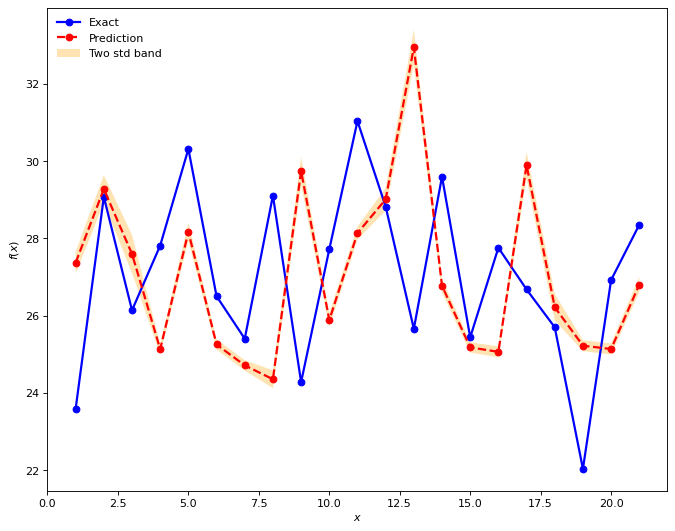

In [75]:
file_write_obj = open("3.7/3.Adam-feature16-MSE-PCA8.txt", 'w')
# for var in mylist:
#     file_write_obj.writelines(var)
#     file_write_obj.write('\n')


# Check accuracy                       
error = np.linalg.norm(y_pred - y_star,2) / np.linalg.norm(y_star,2)
print("Relative L2 error u: %e" % (error))

file_write_obj.write('Relative L2 error')
file_write_obj.write(str(error))
file_write_obj.write('\n')

index=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]

y_pred=np.array(y_pred)
y_star=np.array(y_star)

current=-2
current_i=0
for i in range(700):
    y_pred_a=y_pred-i*0.01
    if r2_score(y_star,y_pred_a)>current:
        current=r2_score(y_star,y_pred_a)
        current_i=i

y_pred-=current_i*0.01
print(current_i*0.01)
    

print("r2 socre:",r2_score(y_star,y_pred))
print("mse:",mean_squared_error(y_star,y_pred))

file_write_obj.write('r2 socre')
file_write_obj.writelines(str(r2_score(y_star,y_pred)))
file_write_obj.write('\n')

print(y_star.T)
print(y_pred.T)

file_write_obj.write('Exact')
file_write_obj.write(str(y_star))
file_write_obj.write('\n')

file_write_obj.write('Predict')
file_write_obj.write(str(y_pred))
file_write_obj.write('\n')

y_var_new=np.abs(np.diag(y_var))
print(y_var_new)

file_write_obj.write('std')
file_write_obj.write(str(y_var_new))
file_write_obj.write('\n')

# Plot
plt.figure(1, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif', size=12)


# plt.plot(X_star, y_star, 'b-', label = "Exact", linewidth=2)
# plt.plot(X_star, y_pred, 'r--', label = "Prediction", linewidth=2)
plt.plot(index, y_star, 'o-',color='blue',label = "Exact", linewidth=2)
plt.plot(index, y_pred, 'o--', color='red',label = "Prediction", linewidth=2)


lower = np.array(y_pred - 2.0*np.sqrt(y_var_new[:,None]))
upper = np.array(y_pred + 2.0*np.sqrt(y_var_new[:,None]))

                     
index=np.array(index)
plt.fill_between(index.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.3, label="Two std band")
# plt.plot(X_H,y_H,'bo', markersize = 1, label = "High-fidelity data")
# plt.plot(X_L,y_L,'ms', markersize = 1, label = "Low-fidelity data")
plt.legend(frameon=False,loc='upper left')
ax = plt.gca()
plt.xlabel('$x$')
plt.ylabel('$f(x)$')

plt.savefig("3.7/3.Adam-feature16-MSE-PCA8.png")
file_write_obj.close()


In [76]:
torch.save(state,'3.7/3.modelParams.pth')

In [77]:
y_pred2, y_var2 = model.predict(X_H)
y_pred2, y_var2 = y_pred2.detach().numpy(), y_var2.detach().numpy()

Relative L2 error u: 1.106885e-01
r2 socre: 0.9999689498562989
[[31.1779]
 [29.1824]
 [26.4095]
 [26.9644]
 [30.09  ]
 [26.837 ]
 [25.28  ]
 [31.4606]
 [30.1555]] [[31.164185]
 [29.175293]
 [26.399048]
 [26.948303]
 [30.083374]
 [26.823608]
 [25.262878]
 [31.451782]
 [30.146301]]
[0.01643312 0.01604366 0.01473677 0.01317835 0.01662409 0.01429498
 0.01534617 0.01680636 0.01668692]


Text(0, 0.5, '$f(x)$')

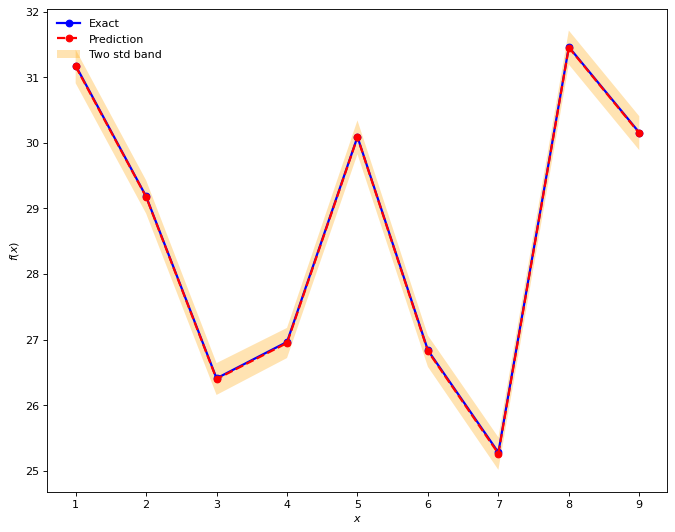

In [78]:

# Check accuracy                       
error = np.linalg.norm(y_pred - y_star,2) / np.linalg.norm(y_star,2)
print("Relative L2 error u: %e" % (error))

index=[1,2,3,4,5,6,7,8,9]

y_pred2=np.array(y_pred2)
y_star2=np.array(y_H)

print("r2 socre:",r2_score(y_star2,y_pred2))

print(y_star2, y_pred2)

y_var_new2=np.abs(np.diag(y_var2))
print(y_var_new2)


# Plot
plt.figure(1, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif', size=12)


# plt.plot(X_star, y_star, 'b-', label = "Exact", linewidth=2)
# plt.plot(X_star, y_pred, 'r--', label = "Prediction", linewidth=2)
plt.plot(index, y_star2, 'o-',color='blue',label = "Exact", linewidth=2)
plt.plot(index, y_pred2, 'o--', color='red',label = "Prediction", linewidth=2)


lower = np.array(y_pred2 - 2.0*np.sqrt(y_var_new2[:,None]))
upper = np.array(y_pred2 + 2.0*np.sqrt(y_var_new2[:,None]))

                     
index=np.array(index)
plt.fill_between(index.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.3, label="Two std band")
# plt.plot(X_H,y_H,'bo', markersize = 1, label = "High-fidelity data")
# plt.plot(X_L,y_L,'ms', markersize = 1, label = "Low-fidelity data")
plt.legend(frameon=False,loc='upper left')
ax = plt.gca()
plt.xlabel('$x$')
plt.ylabel('$f(x)$')




In [79]:
yyPre=np.vstack((y_pred,y_pred2))
yyExa=np.vstack((y_star,y_star2))
yyVar=np.hstack((y_var_new,y_var_new2))
xx=np.vstack((X_star,X_H)).mean(axis=1)
print(xx.size)

zipped=zip(xx,yyPre,yyExa,yyVar)
sort_zipped = sorted(zipped,key=lambda x:(x[0],x[1],x[2],x[3]))
result=zip(*sort_zipped)
X_draw,y_pred_draw,y_star_draw,y_var_draw=[list(x) for x in result]

plt.figure(1, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')

plt.plot(X_draw, y_star_draw, 'o-',color='blue', label = "Exact", linewidth=2)
plt.plot(X_draw, y_pred_draw, 'o--', color='red',label = "Prediction", linewidth=2)

y_var_draw=np.array(y_var_draw)
lower = np.array(y_pred_draw - 2.0*np.sqrt(y_var_draw[:,None]))
upper = np.array(y_pred_draw + 2.0*np.sqrt(y_var_draw[:,None]))
                    
X_draw=np.array(X_draw)
plt.fill_between(X_draw.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.3, label="Two std band")
# plt.plot(X_H,y_H,'bo', markersize = 1, label = "High-fidelity data")
# plt.plot(X_L,y_L,'ms', markersize = 1, label = "Low-fidelity data")
plt.legend(frameon=False,loc='upper left')
ax = plt.gca()
plt.xlabel('$x$')
plt.ylabel('$f(x)$')

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 4 and the array at index 1 has size 8